In [1]:
# Import the required modules.

import numpy as np
import pandas as pd
import json
import cv2
import random

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec

from imutils import perspective
from imutils import contours
import imutils

from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
df = pd.read_csv('E:\\Documents\\PostDoc\\know_fusion_labels\\astroecology_classifications_processed.csv')

random.seed(1)

In [3]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)


def get_boxes_for_image_k(k, df):
    
    import os

    targ = df.filename[k]

    # Read in the images for creating bounding boxes from coordinate tags.
    img = cv2.imread(os.path.join('E:\\Documents\\PostDoc\\know_fusion_images', targ))
    
    # Convert into grayscale and into a numpy array.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.array(img)
    
    # Plot the image and show the tagged coordinates as crosshairs.
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    #plt.imshow(img)

    labs = df[df.filename == df.filename[k]]
    labs.index = range(len(labs))
    #for i in range(len(labs)):
    #    plt.plot(labs.x[i], labs.y[i], 'b+', color='red', markersize = 18)
        
    # For each of the tags, cut out a 20 by 20 pixel region centred on them.

    x_t = []
    y_t = []
    b_t = []

    cut = 255 - img

    for i in range(len(labs)):
    
        # Get the coordinates of the maximum pixel in the 20x20 pixel region.
    
        xx = np.repeat(np.power(range(640) - labs.x[i], 2.0)[np.newaxis,:], 512, 0)
    
        yy = np.repeat(np.power(range(512) - labs.y[i], 2.0)[np.newaxis,:], 640, 0).transpose()
    
        xy = np.sqrt(xx + yy)
    
        fin = 255 * (xy / np.max(xy))
    
        both = 0.9*fin + 0.1*cut
    
        x_c = np.where(both == np.amin(both))[0][0]
        y_c = np.where(both == np.amin(both))[1][0]

        x_t.append(y_c)
        y_t.append(x_c)
        b_t.append(img[x_c, y_c])
        
    labs['x_t'] = pd.Series(x_t)
    labs['y_t'] = pd.Series(y_t)
    labs['b_t'] = pd.Series(b_t)

    # Plot the image and show the tagged coordinates as crosshairs.
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    #plt.imshow(img)

    #for i in range(len(labs)):
    #    plt.plot(labs.x_t[i], labs.y_t[i], 'b+', color='red', markersize = 18)
        
    # For each classified image, work out the boxes for each of the tags.

    unique_class = np.unique(labs['classification_id'])

    for j in range(len(unique_class)):
        labset = labs[labs.classification_id == unique_class[j]]
        labset.sort_values(by=['x'])
        labset.index = range(len(labset))
    
        # Find the boxes.
    
        x_min = []
        x_max = []
        y_min = []
        y_max = []
    
        for k in range(len(labset)):
        
            x_cand_1 = labset.x_t[k]
            x_cand_2 = labset.x_t[k]
            y_cand_1 = labset.y_t[k]
            y_cand_2 = labset.y_t[k]
        
            x_min.append(x_cand_1 - 5)
            x_max.append(x_cand_2 + 5)
        
            y_min.append(y_cand_1 - 5)
            y_max.append(y_cand_2 + 5)
        
        labset['x_min'] = x_min
        labset['x_max'] = x_max
        labset['y_min'] = y_min
        labset['y_max'] = y_max

    img = cv2.imread(os.path.join('E:\\Documents\\PostDoc\\know_fusion_images', targ))
    ori = img.copy()
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.medianBlur(img,5)

    sizey, sizex = img.shape

    rang = 5
    os = 2

    th = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,rang,os)

    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    #plt.imshow(th)

    #for i in range(len(labs)):
    #    plt.plot(labs.x_t[i], labs.y_t[i], 'b+', color='red', markersize = 18)
        
    image = th
    image = cv2.bitwise_not(image)

    edged = cv2.Canny(image, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    #plt.imshow(edged)

    cnts, harchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    (cnts, _) = contours.sort_contours(cnts)
    
    areas = []

    box_x = []
    box_y = []
    box_w = []
    box_h = []

    for c in cnts:

        areas.append(cv2.contourArea(c))

        orig = img.copy()
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")

        box = perspective.order_points(box)

        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)

        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)

        x, y, w, h = cv2.boundingRect(c)
    
        box_x.append(x)
        box_y.append(y)
        box_w.append(w)
        box_h.append(h)
    
    # Turn the lists into a pandas dataframe.
    boxes = pd.DataFrame({'x': box_x, 'y': box_y, 'w': box_w, 'h': box_h}, columns=['x','y','w','h'])

    boxes['a'] = boxes['w'] * boxes['h']

    boxes = boxes[boxes['a'] < 1000]

    boxes['keep'] = 0

    boxes.index = range(len(boxes))

    # Reject boxes without a tag inside.

    for i in range(len(labs)):
        for j in range(len(boxes)):
            if (boxes['x'][j] <= labs.x_t[i] and (boxes['x'][j]+boxes['w'][j]) >= labs.x_t[i] and boxes['y'][j] <= labs.y_t[i] and (boxes['y'][j]+boxes['h'][j]) >= labs.y_t[i]):
                boxes['keep'][j] = 1
            
            
    boxes = boxes[boxes['keep'] == 1]

    boxes.index = range(len(boxes))

    labs['empty'] = 0

    boxfin = []

    for i in range(len(labs)):
        boxlabs = boxes
        boxlabs['keep'] = 0
        for j in range(len(boxlabs)):
            if (boxlabs['x'][j] <= labs.x_t[i] and (boxlabs['x'][j]+boxlabs['w'][j]) >= labs.x_t[i] and boxlabs['y'][j] <= labs.y_t[i] and (boxlabs['y'][j]+boxlabs['h'][j]) >= labs.y_t[i]):
                boxlabs['keep'][j] = 1
            
        boxlabs = boxlabs[boxlabs['keep'] == 1]
    
        if boxlabs.empty:
            labs['empty'][i] = 1
        else:
            boxlabs = boxlabs[boxlabs['a'] == np.amax(boxlabs['a'].values)]
        
            boxlabs.index = range(len(boxlabs))
    
            boxlabs = boxlabs.iloc[[0]]
        
            boxfin.append(boxlabs)
    
    boxfin = pd.concat(boxfin)

    boxfin.index = range(len(boxfin))
        
    labs = labs[labs['empty'] == 0]

    labs.index = range(len(labs))

    # Now that we have a dataframe of labels and a dataframe of associated maxsize boxes, compute unique and aggregate.

    boxuni = boxfin.drop_duplicates()

    boxuni.index = range(len(boxuni))

    tool_final = []

    tool_label_final = []

    for i in range(len(boxuni)):
    
        duplicates = (boxfin[(boxfin['x'] == boxuni['x'][i]) & (boxfin['y'] == boxuni['y'][i]) & (boxfin['w'] == boxuni['w'][i]) & (boxfin['h'] == boxuni['h'][i])].index.values)

        tool_final.append(labs.iloc[duplicates].tool.max())
    
        tool_label_final.append(labs.iloc[duplicates].tool_label.max())

    boxuni['tool_final'] = tool_final

    boxuni['tool_label_final'] = tool_label_final

    fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    gs  = gridspec.GridSpec(1, 1, height_ratios=[1])
    ax = plt.subplot(gs[0])

    # Display the image
    ax.imshow(ori)

    #for i in range(len(labs)):
    #    plt.plot(labs.x_t[i], labs.y_t[i], 'b+', color='red', markersize = 18)
    
    for i in range(len(boxuni)):
        rect = patches.Rectangle((boxuni['x'][i],boxuni['y'][i]),boxuni['w'][i],boxuni['h'][i],linewidth=4,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
    return boxuni

<ipython-input-3-c61ea016f840>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-3-c61ea016f840>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-3-c61ea016f840>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

x    y   w   h    a  keep  tool_final tool_label_final
0   48  240  22  17  374     1           4            Rhino
1  236  241  18  14  252     1           4            Rhino
2  336  225  14   8  112     1           4            Rhino
3  356  225  12   8   96     1           4            Rhino
4  276  217  21   8  168     1           4            Rhino
5  308  220   6   6   36     1           4            Rhino

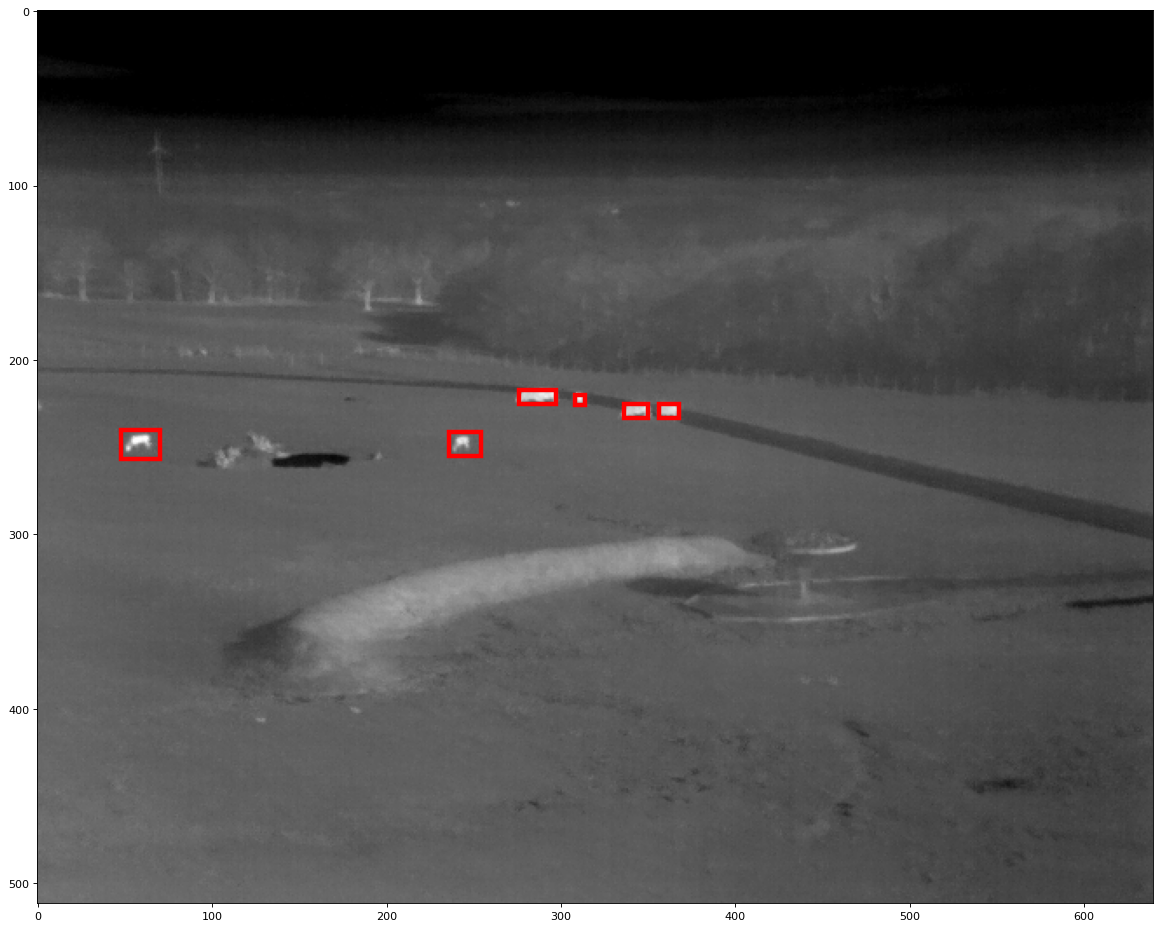

In [4]:
get_boxes_for_image_k(random.randrange(0, len(df.filename), 1), df)

<ipython-input-3-c61ea016f840>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-3-c61ea016f840>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-3-c61ea016f840>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

x    y   w   h    a  keep  tool_final tool_label_final
0  604  291  19  18  342     1           4            Rhino
1  547  193  13   9  117     1           4            Rhino
2  360  253   9  13  117     1           4            Rhino
3  244  258  22  14  308     1           4            Rhino
4  284  288  11  24  264     1           4            Rhino

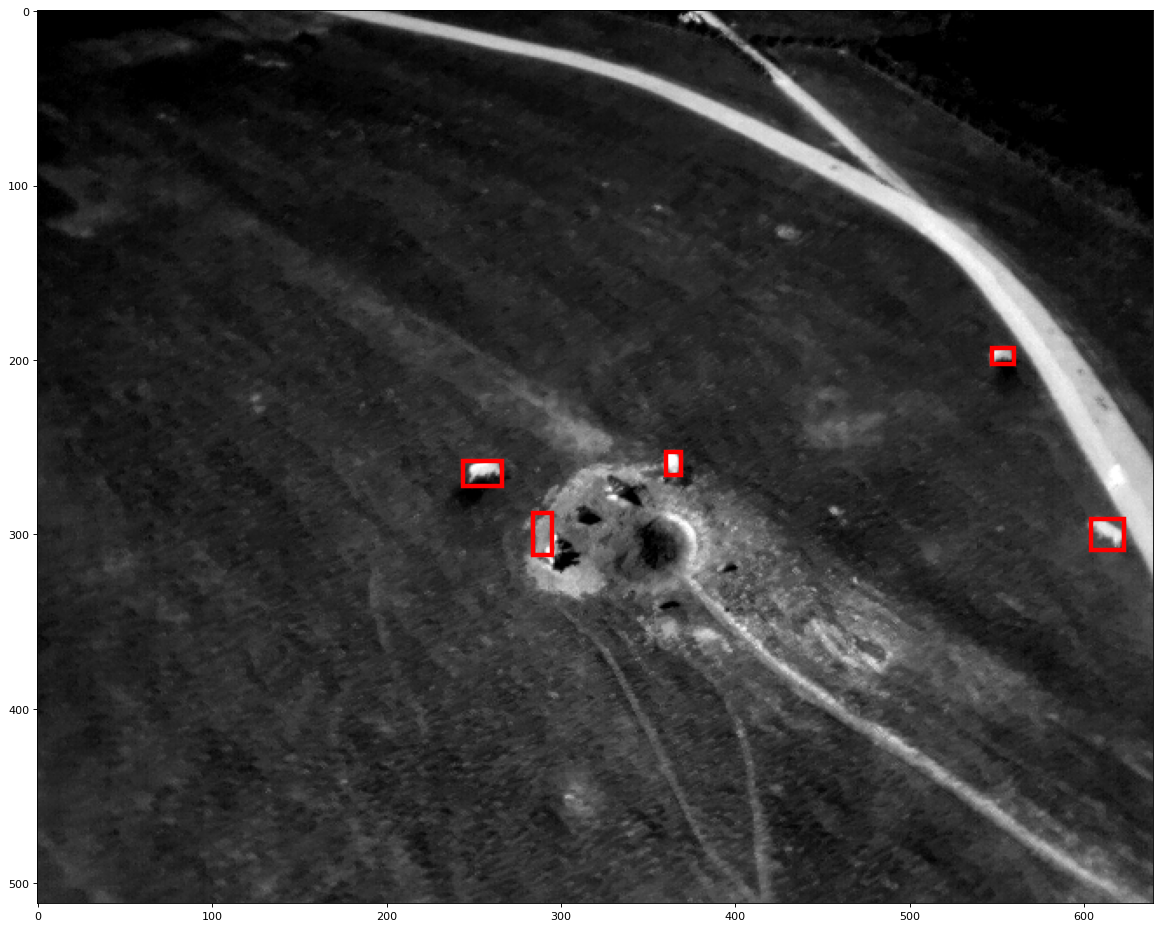

In [5]:
get_boxes_for_image_k(random.randrange(0, len(df.filename), 1), df)

<ipython-input-3-c61ea016f840>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-3-c61ea016f840>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-3-c61ea016f840>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

x    y   w   h    a  keep  tool_final tool_label_final
0  286  237  24  21  504     1           4            Rhino
1  355  254  28  16  448     1           4            Rhino
2  339  312  24  18  432     1           4            Rhino
3  407  323  29  15  435     1           4            Rhino
4  534  327  18  18  324     1           4            Rhino
5  378  248  10   9   90     1           4            Rhino

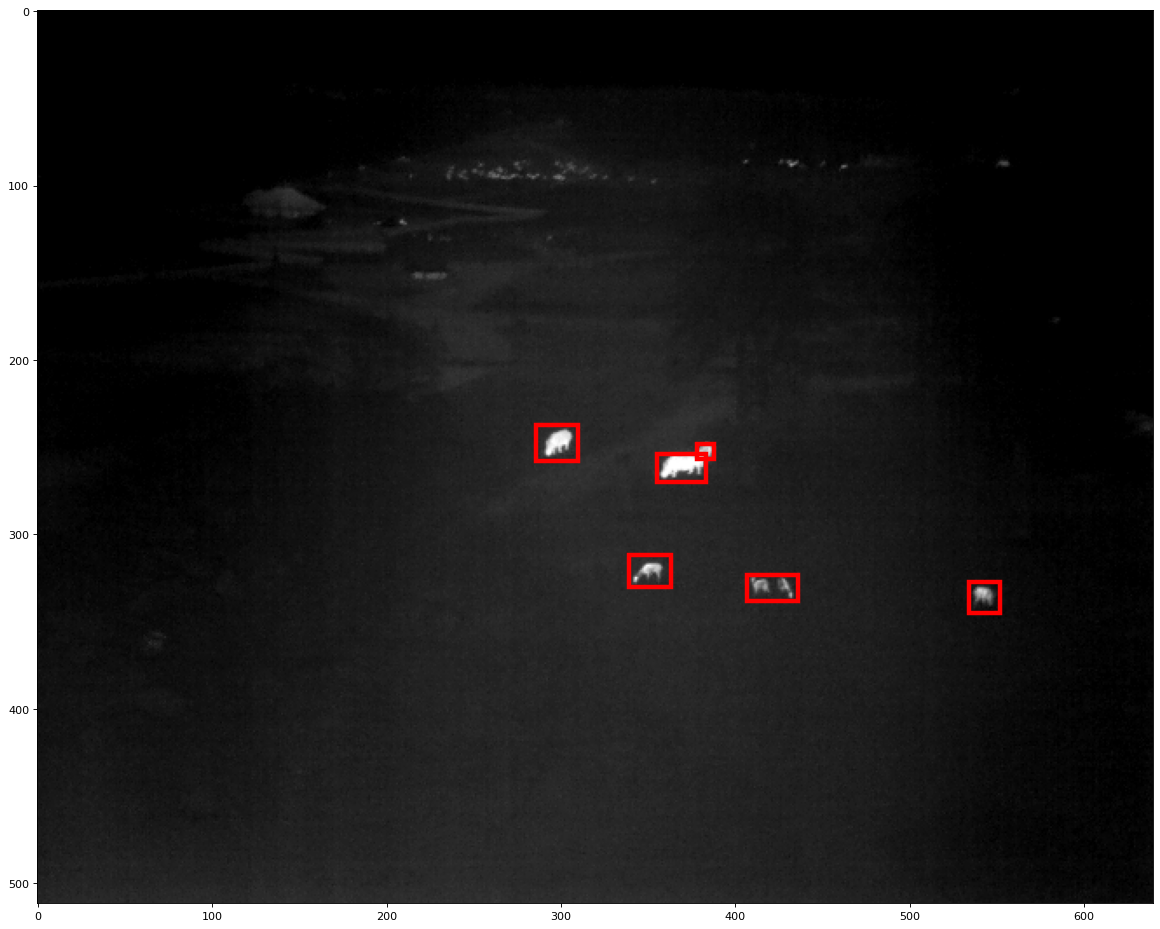

In [6]:
get_boxes_for_image_k(random.randrange(0, len(df.filename), 1), df)

<ipython-input-3-c61ea016f840>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-3-c61ea016f840>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-3-c61ea016f840>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

x    y   w  h   a  keep  tool_final tool_label_final
0  607  268   8  6  48     1           2         Antelope
1  543  273   7  8  56     1           2         Antelope
2  591  270  11  7  77     1           2         Antelope
3  590  260   7  6  42     1           2         Antelope
4  344  221   9  6  54     1           4            Rhino
5  207  202   7  5  35     1           2         Antelope
6  171  199   8  8  64     1           2         Antelope
7  191  199   7  9  63     1           2         Antelope
8  206  206   7  6  42     1           2         Antelope

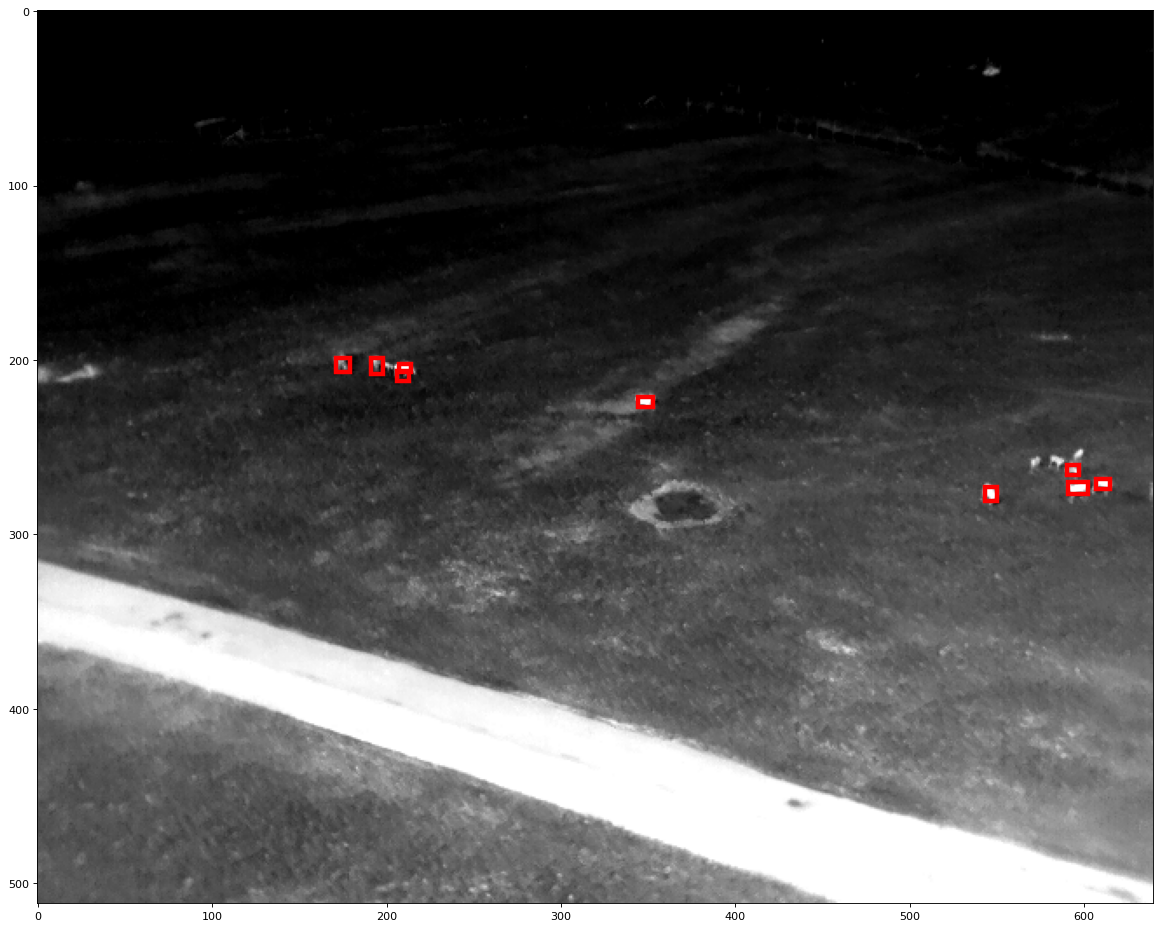

In [7]:
get_boxes_for_image_k(random.randrange(0, len(df.filename), 1), df)

<ipython-input-3-c61ea016f840>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-3-c61ea016f840>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-3-c61ea016f840>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

x    y   w   h    a  keep  tool_final tool_label_final
0  314  343  25  17  425     1           4            Rhino
1  295  343  16  19  304     1           4            Rhino
2  458  278  33  27  891     1           4            Rhino

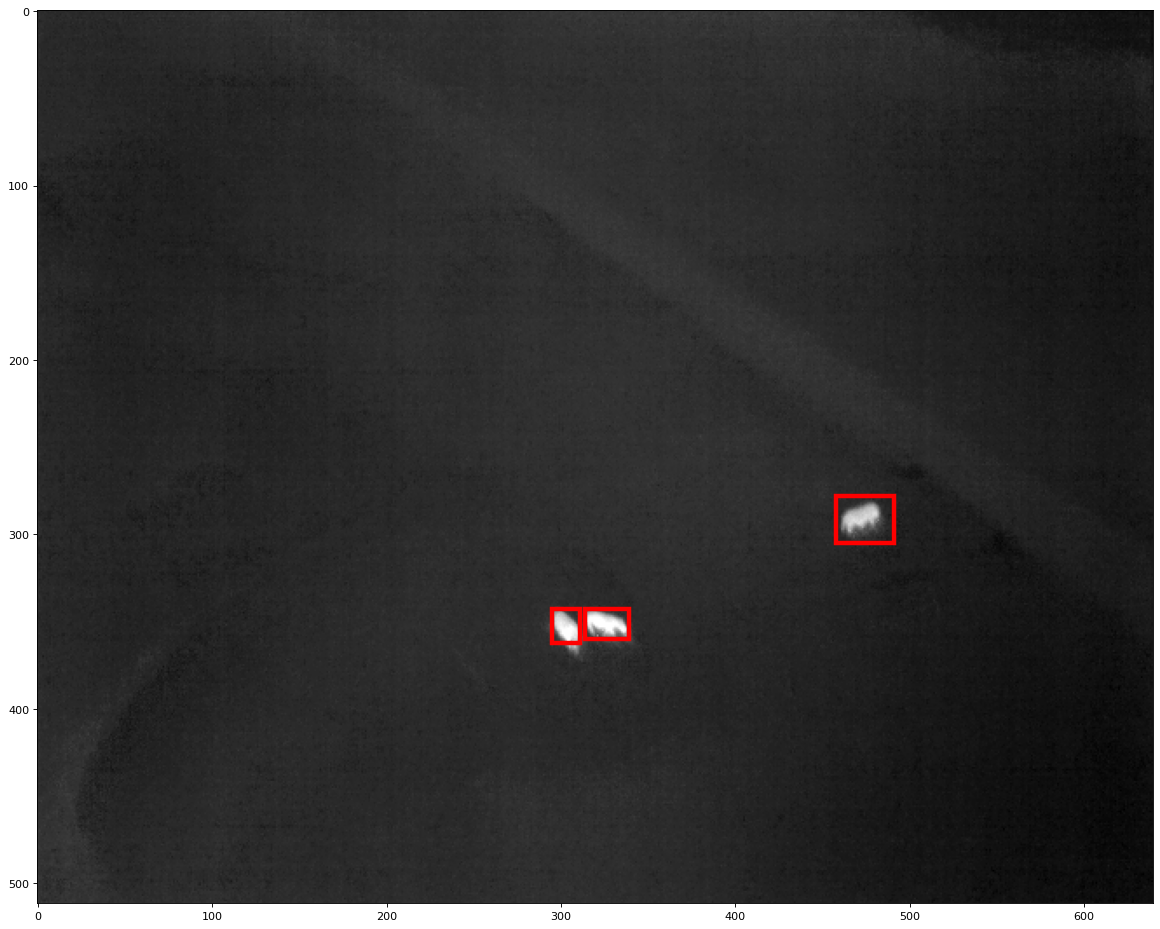

In [8]:
get_boxes_for_image_k(random.randrange(0, len(df.filename), 1), df)

<ipython-input-3-c61ea016f840>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-3-c61ea016f840>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-3-c61ea016f840>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

x    y   w   h    a  keep  tool_final tool_label_final
0  121  143  34  17  578     1           4            Rhino
1  165  318  19  18  342     1           4            Rhino
2   89  174  15  13  195     1           4            Rhino
3    2  170  18  14  252     1           4            Rhino
4   34  197  10   8   80     1           4            Rhino
5   45  182  27  14  378     1           4            Rhino

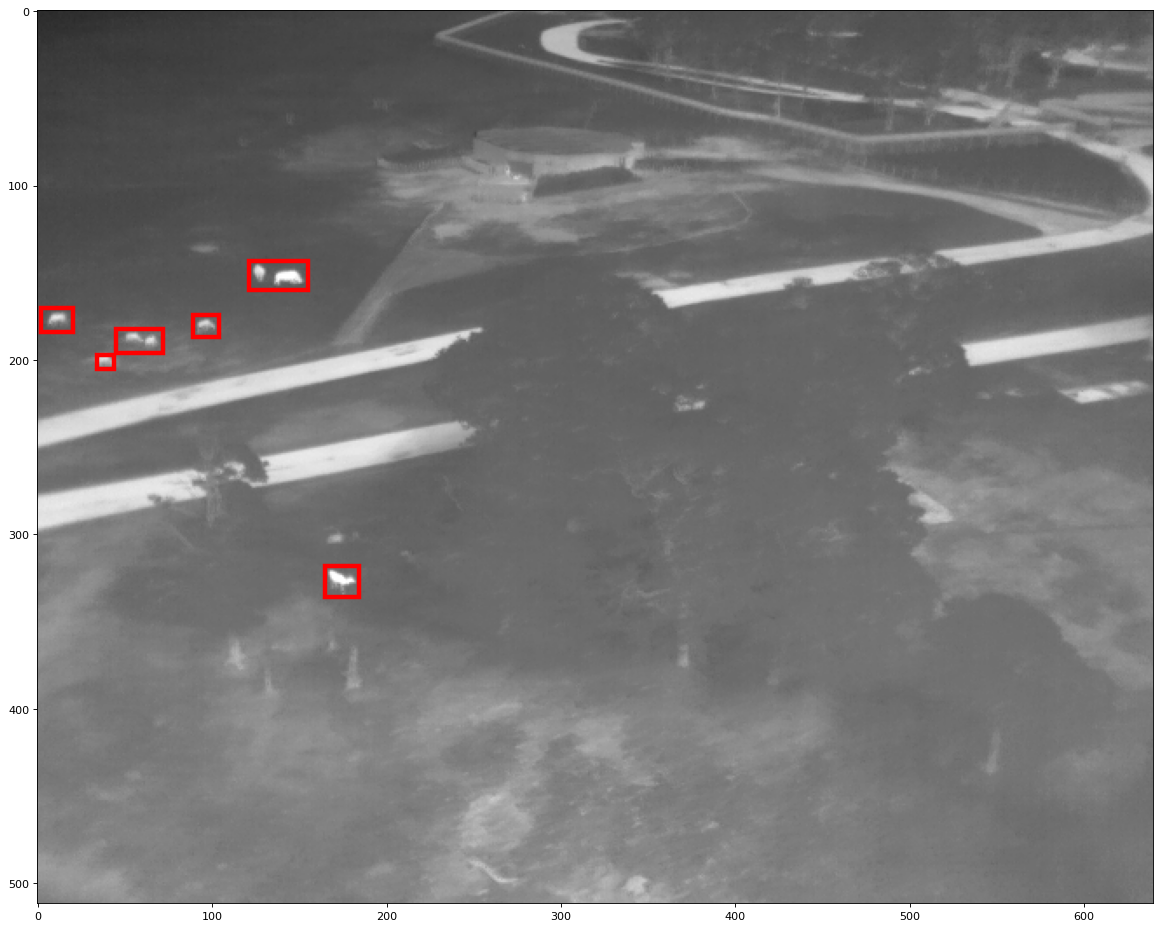

In [9]:
get_boxes_for_image_k(random.randrange(0, len(df.filename), 1), df)

<ipython-input-3-c61ea016f840>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-3-c61ea016f840>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-3-c61ea016f840>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

x    y   w   h    a  keep  tool_final tool_label_final
0  132  175  25  16  400     1           4            Rhino
1  102  209  14  13  182     1           2         Antelope
2   62  218  26  15  390     1           2         Antelope
3   40  233  27  17  459     1           2         Antelope
4   23  210  17  14  238     1           4            Rhino

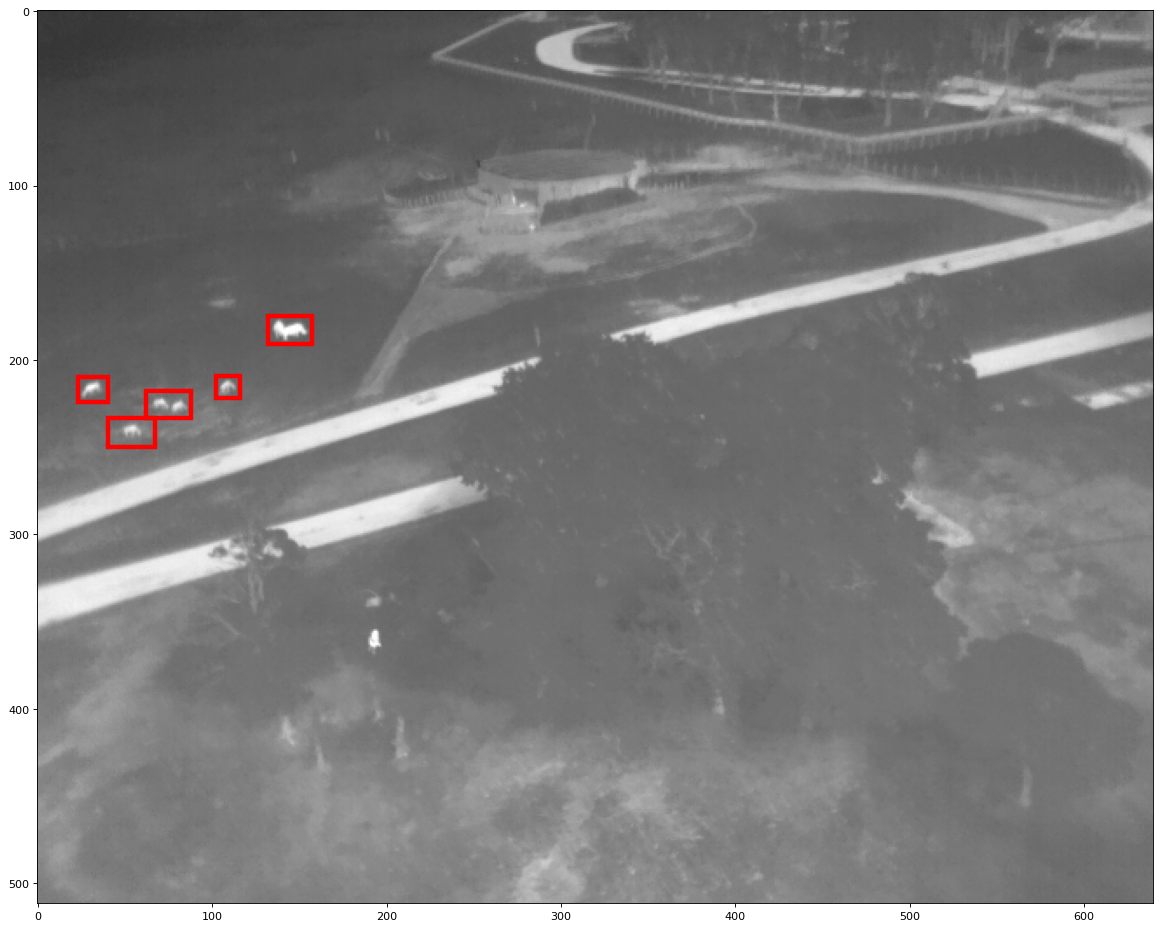

In [10]:
get_boxes_for_image_k(random.randrange(0, len(df.filename), 1), df)

<ipython-input-3-c61ea016f840>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-3-c61ea016f840>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-3-c61ea016f840>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

x    y   w   h    a  keep  tool_final tool_label_final
0  200  209  16  14  224     1           4            Rhino
1  308  202  21  20  420     1           4            Rhino
2  381  297  11  11  121     1           4            Rhino
3  375  307  12   9  108     1           4            Rhino
4  225  417  20  15  300     1           2         Antelope
5  399  304  12  10  120     1           4            Rhino

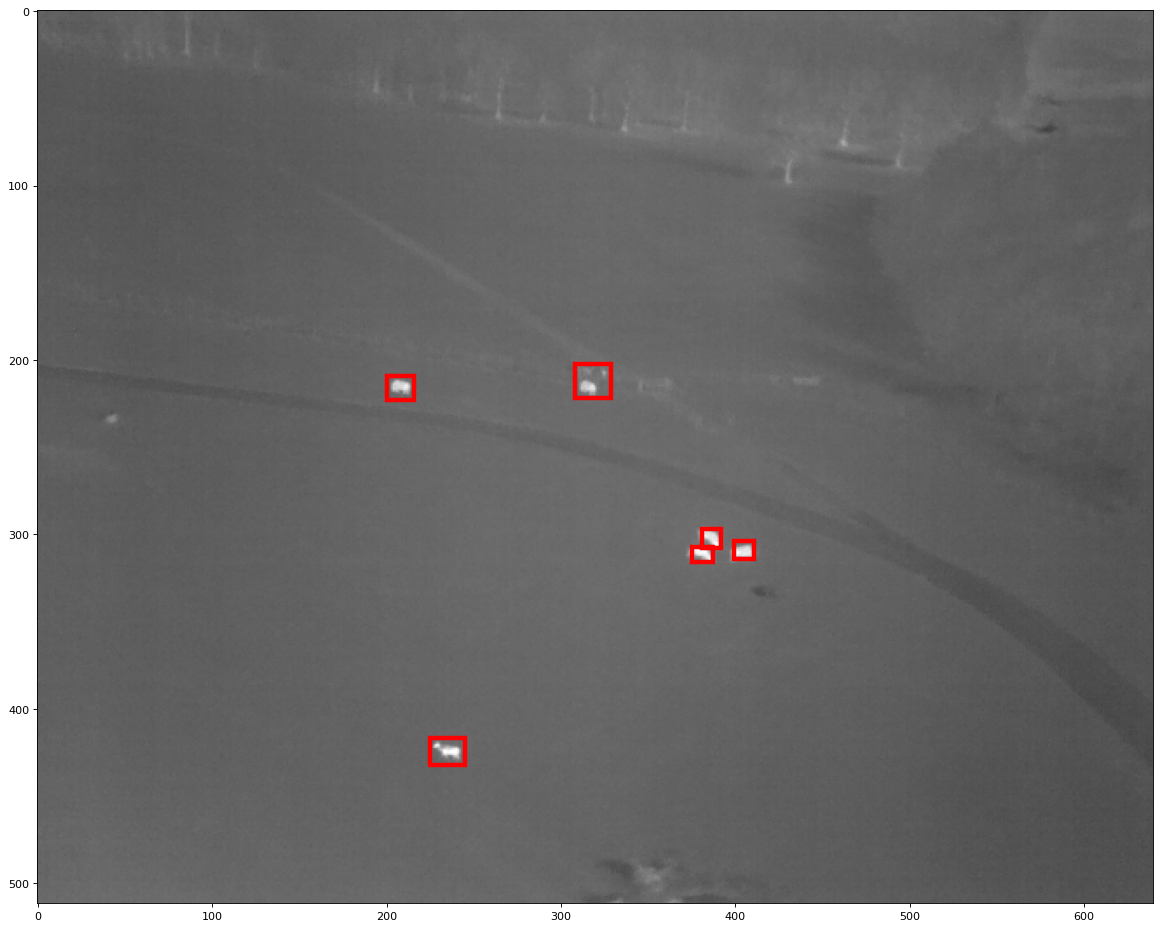

In [11]:
get_boxes_for_image_k(random.randrange(0, len(df.filename), 1), df)

<ipython-input-3-c61ea016f840>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-3-c61ea016f840>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-3-c61ea016f840>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

x    y   w   h    a  keep  tool_final tool_label_final
0   375  273  50  18  900     1           3            Human
1   511  264  38  18  684     1           3            Human
2   348  300  10   7   70     1           3            Human
3   238  323  10  13  130     1           3            Human
4   312  161   8   7   56     1           3            Human
5   433   87  19  12  228     1           3            Human
6   388  177  29  22  638     1           3            Human
7   441  421  25  22  550     1           3            Human
8   565   52  41  18  738     1           3            Human
9   364   53   7   7   49     1           3            Human
10  400   61   8   7   56     1           3            Human
11  489   70  12  14  168     1           3            Human
12   27  108  45  14  630     1           3            Human
13  280  362   7   8   56     1           3            Human

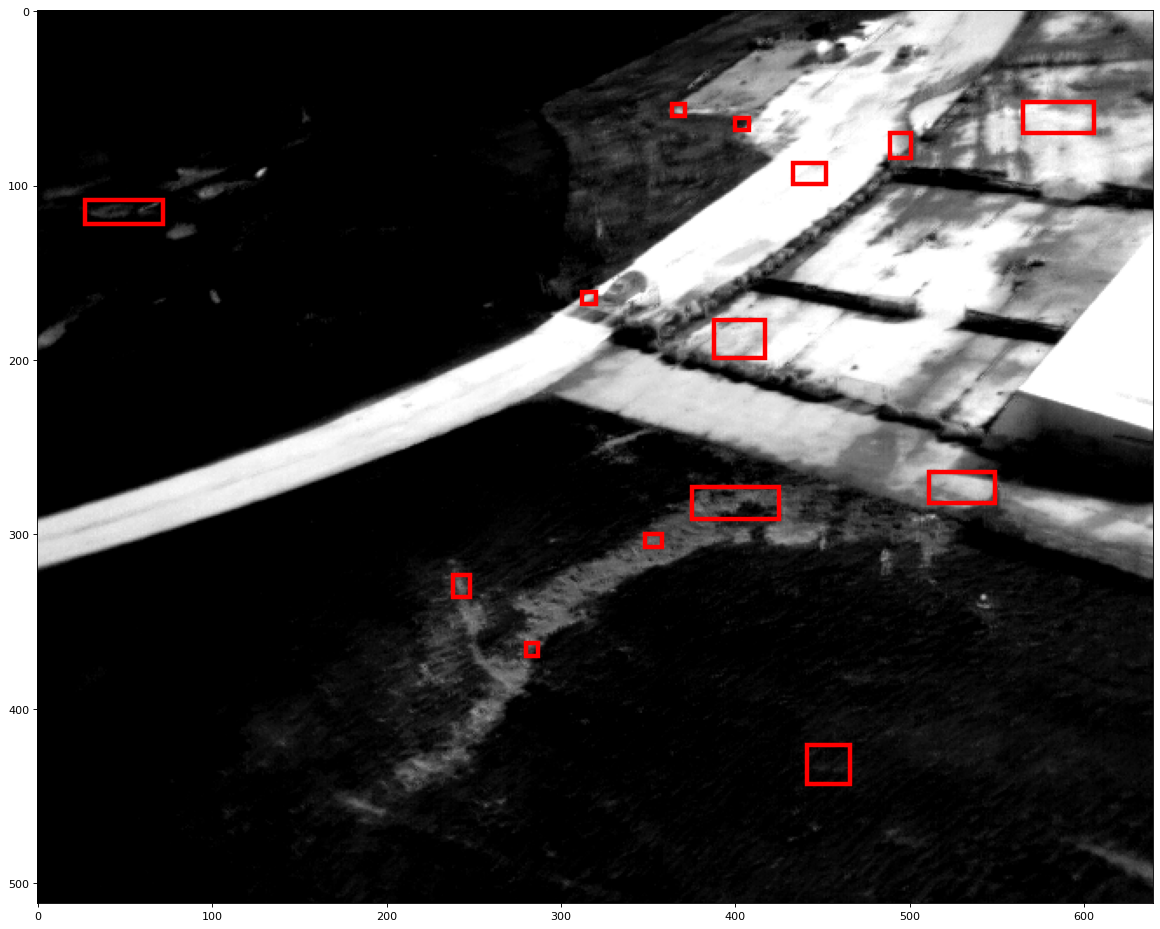

In [12]:
get_boxes_for_image_k(random.randrange(0, len(df.filename), 1), df)

<ipython-input-3-c61ea016f840>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['x_t'] = pd.Series(x_t)
<ipython-input-3-c61ea016f840>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labs['y_t'] = pd.Series(y_t)
<ipython-input-3-c61ea016f840>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

x    y   w   h    a  keep  tool_final tool_label_final
0   99  246  20  16  320     1           4            Rhino
1  157  250  14  15  210     1           4            Rhino
2  187  274  13  17  221     1           4            Rhino
3  224  280  16  12  192     1           4            Rhino
4  321  366  30  29  870     1           2         Antelope

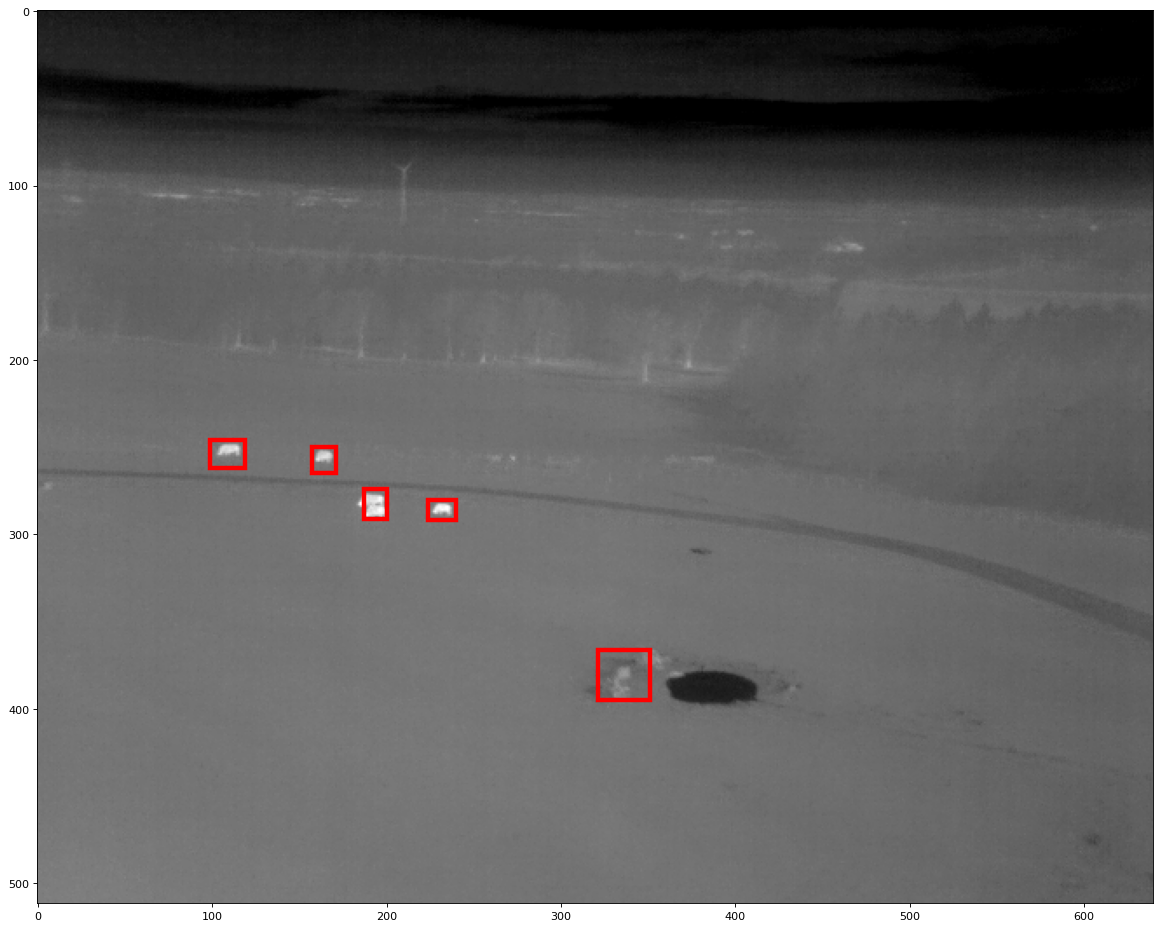

In [13]:
get_boxes_for_image_k(random.randrange(0, len(df.filename), 1), df)